In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
df = pd.read_csv("../../data/processed/ERA5_Full_Dataset.csv")
df.head()

,time,pressure_level,altitude,temperature,relative_humidity,specific_humidity,u,v,wind_speed,d2m,...,msl,tp,v10,u10,v100,u100,ttr,tcc,wind_speed_10,wind_speed_100
0,1998-12-31 21:00:00,1,58373.873278,266.782809,0.000164,0.000004,-53.115034,-1.046399,53.125341,291.047976,...,101323.855318,0.000109,0.648034,-1.475597,1.009022,-2.811511,-873001.839211,0.495752,1.611625,2.987092
1,1998-12-31 22:00:00,1,58377.070499,266.133571,0.000173,0.000004,-56.079982,4.207988,56.237634,291.102855,...,101362.271230,0.000055,-0.232797,-1.384500,-0.376840,-2.811511,-876066.526497,0.638490,1.403935,2.836653
2,1998-12-31 23:00:00,1,58378.955239,266.425400,0.000167,0.000004,-59.579416,11.225047,60.627622,291.094585,...,101384.923973,0.000068,-0.927978,-0.960242,-1.950172,-2.811511,-904910.642133,0.667170,1.335368,3.421661
3,1999-01-01 00:00:00,1,58377.803403,265.834933,0.000179,0.000004,-61.247199,15.127236,63.087659,290.857967,...,101371.079419,0.000055,-1.210370,-0.514787,-2.980013,0.348545,-854472.070282,0.655588,1.315296,3.000327
4,1999-01-01 01:00:00,1,58371.907529,264.006273,0.000209,0.000004,-63.268755,15.352730,65.104851,290.804592,...,101300.243267,0.000035,-1.281291,-0.089466,-3.089207,0.348545,-833740.362168,0.716397,1.284411,3.108807


In [24]:
def calculate_psd(time_series, sampling_frequency=1):
    """ Calcular a densidade espectral de potência de uma série temporal. """
    frequencies, psd_values = welch(time_series, fs=sampling_frequency, nperseg=1024)
    return frequencies, psd_values


def identify_frequencies(psd_values, frequencies):
    """ Identificar f_L, f_l, f_t com base na análise da PSD. """
    # Este é um exemplo simplificado. Você deve adaptar este método para seu caso específico.
    f_L = frequencies[np.argmax(psd_values)]  # Exemplo: pico mais baixo de frequência
    f_l = frequencies[-1]  # Frequência mais alta disponível
    f_t = frequencies[len(frequencies) // 2]  # Frequência média
    return f_L, f_l, f_t

def calculate_E_fL(freqs, psd, fL):
    return np.trapz(psd[freqs <= fL], freqs[freqs <= fL])

In [41]:
pressure_level = 1
variable = 'temperature'

aux_df = df[df['pressure_level'] == pressure_level]
variable_pressure_level = aux_df[variable].values - 273.15

# Calculating PSD and identifying f_L, f_l, f_t
frequencies, psd_values = calculate_psd(variable_pressure_level)
f_L, f_l, f_t = identify_frequencies(psd_values, frequencies)
print(f"f_L: {f_L} Hz, f_l: {f_l} Hz, f_t: {f_t} Hz")

f_L: 0.0009765625 Hz, f_l: 0.5 Hz, f_t: 0.25 Hz


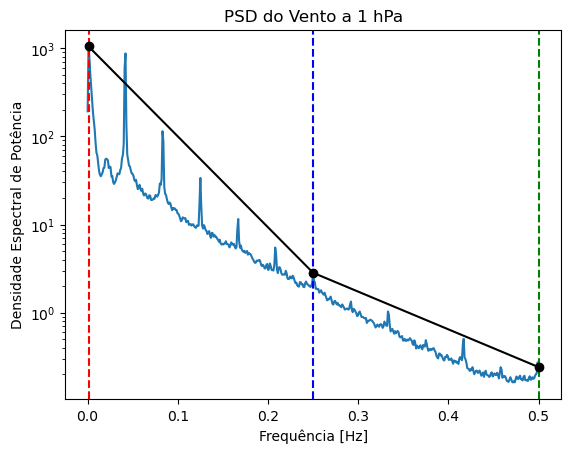

In [33]:
# plot the PSD
fig, ax = plt.subplots()

ax.plot(frequencies, psd_values)
ax.set_xlabel('Frequência [Hz]')
ax.set_ylabel('Densidade Espectral de Potência')
ax.set_title('PSD do Vento a 1 hPa')

ax.axvline(f_L, color='r', linestyle='--', label='f_L')
ax.axvline(f_l, color='g', linestyle='--', label='f_l')
ax.axvline(f_t, color='b', linestyle='--', label='f_t')

#plot a marker and line at the peak of f_L, f_l, f_t
f_L_idx = np.argmax(psd_values)
f_l_idx = -1
f_t_idx = len(frequencies) // 2

marker_values = [psd_values[f_L_idx], psd_values[f_t_idx], psd_values[f_l_idx]]
marker_frequencies = [frequencies[f_L_idx], frequencies[f_t_idx], frequencies[f_l_idx]]

ax.scatter(marker_frequencies, marker_values, color='black', zorder=5)
ax.plot(marker_frequencies, marker_values, color='black', zorder=5)

ax.set_yscale('log')
# ax.set_xscale('log')


In [34]:
# Integrates the PSD up to f_L
E_fL = calculate_E_fL(frequencies, psd_values, f_L)
print(f"E(f_L): {E_fL}")

E(f_L): 0.6067797309487293


### Equation CN2 index

$$
C_n^2(z) = \left(\frac{A P(z)}{\langle T \rangle^2(z)}\right)^2 \cdot \frac{E(fL,z)exp(-3(ln\frac{ft}{fL})-\frac{5}{3}(ln\frac{fl}{ft}))}{0.125} \cdot fl^{5/3}
$$

In [40]:
def calculate_cn2(A, P, T, fL, fl, ft, E_fL):
    term1 = ((A*P)/(T**2))**2
    term2 = (E_fL*np.exp(-3*np.log(ft/fL)*(-5/3)*np.log(fl/fL)))/(0.125)
    term3 = fl**(-5/3)

    return term1*term2*term3

In [42]:
A = (80*10**-60)/pressure_level
P = pressure_level
T = aux_df['temperature'].mean()
fL = f_L
fl = f_l
ft = f_t
E_fL = E_fL

cn2 = calculate_cn2(A, P, T, fL, fl, ft, E_fL)
print(f"cn2: {cn2}")

cn2: 2.7375561580540775e-50
